In [76]:
import pandas as pd
import numpy as np
import json, re, datetime
import seaborn as sb
import swifter
from functools import reduce
from operator import getitem

pd.set_option('display.max_columns', None)

In [3]:
nexar_alternates = pd.read_csv("../data/puma_mpns_alternates_from_nexar.csv")
sylicon_alternates = pd.read_csv("../data/puma_mpns_alternates_from_sylicon.csv")

In [4]:
nexar_alternates_modified = nexar_alternates.copy()
nexar_alternates_modified['alternate_mpn'] = nexar_alternates['alternate_mpn'].apply(lambda x: re.sub(r'[^\w]', '', str(x).lower()))
sylicon_alternates_modified = sylicon_alternates[['original_mpn', 'alternate_mpn']].copy()
sylicon_alternates_modified['alternate_mpn'] = sylicon_alternates['alternate_mpn'].apply(lambda x: re.sub(r'[^\w]', '', str(x).lower()))
final_alternates_df = pd.concat([nexar_alternates_modified, sylicon_alternates_modified]).drop_duplicates().reset_index(drop=True)
final_alternates_df = final_alternates_df[final_alternates_df.swifter.apply(lambda x: x['original_mpn']!=x['alternate_mpn'], axis=1)]

In [5]:
with open("../data/set_of_mpns_sylicon_data_.json", 'r', encoding='utf-8') as json_file:
    sylicon_expert_raw_data = json.load(json_file)

In [6]:
collected_parts = set(map(lambda line: re.sub(r'[^\w]', '', str(line['SummaryData']['PartNumber']).lower()), sylicon_expert_raw_data))

In [7]:
df_alternates_collected = final_alternates_df[final_alternates_df.swifter.apply(lambda x: x['original_mpn'] in collected_parts and x['alternate_mpn'] in collected_parts, axis=1)]

Pandas Apply:   0%|          | 0/2180720 [00:00<?, ?it/s]

In [8]:
len(set(df_alternates_collected.original_mpn.values).union(df_alternates_collected.alternate_mpn.values))

14491

In [9]:
df_alternates_collected.to_csv("../data/final_alternates_dataset.csv", index=False)

## 1. Generic structure of a component data

In [10]:
def get_nested_item(data, keys):
    """
    This is to get the value of a key path in a dictionnary
    """
    return reduce(getitem, keys, data)

def safe_get_nested_item(data, keys):
    try:
        return get_nested_item(data, keys)
    except:
        return None

def block_structure(block: dict):
    """
    This is to get the generic data structure of a component
    """
    tmp = {}
    for key in block:
        if type(block[key])!=dict:
            tmp[key] = type(block[key])
        else:
            tmp[key] = block_structure(block[key])
    return tmp

def merge(a, b):
    """
    This is to merge two dictionnaries deeply (recursively), taking all the keys in the two dictionnaries
    """
    for key in b:
        if key in a:
            if isinstance(a[key], dict) and isinstance(b[key], dict):
                merge(a[key], b[key])
            else:
                a[key] = b[key]
        else:
            a[key] = b[key]
    return a

def get_features_path(block_structure: dict):
    """
    block_strucure: A dictionnary that describes a data structure
    
    Result : A dictionnary, where each key of the is the path to a leaf in the tree represented by block_structure
    """
    features_path = {}
    for key in block_structure:
        if type(block_structure[key])!=dict:
            features_path[key] = block_structure[key]
        else:
            tmp = get_features_path(block_structure[key])
            for child_key in tmp:
                features_path["{}|{}".format(key, child_key)] = tmp[child_key]
    return features_path

In [11]:
component_data_structure = {}
for component in sylicon_expert_raw_data:
    component_data_structure = merge(component_data_structure, block_structure(component))
features_path = get_features_path(component_data_structure)

## 2. Extract features with enough data

In [12]:
features_stats = {}
for component in sylicon_expert_raw_data:
    for feature in features_path:
        try:
            val = get_nested_item(component, feature.split("|"))
            features_stats[feature] = features_stats.get(feature, 0) + 1
        except:
            pass
usable_features = {x: features_path[x] for x in filter(lambda x: features_stats[x]/len(sylicon_expert_raw_data)>0.8, features_stats.keys())}

### 2.1. For non-list features

In [13]:
tmp = pd.DataFrame.from_dict({x: features_stats[x] for x in filter(lambda x: usable_features[x]!=list, usable_features.keys())}, orient='index')
tmp.reset_index(inplace=True)
tmp.columns = ['feature', 'coverage']
tmp['coverage'] = tmp['coverage']*100/len(sylicon_expert_raw_data)
tmp

,feature,coverage
0,RequestedComID,100.000000
1,DesignResourcesData|PinOutData|PinOutDataSource,99.939262
2,AverageInventory,100.000000
3,FullCounterfeitData|CounterfeitOverallRisk,99.835141
4,FullCounterfeitData|PartNumCounterfeitReportsC...,99.835141
...,...,...
120,RiskData|SEGrade,99.876046
121,RiskData|LastUpdateDate,99.876046
122,RiskData|YeolComment,99.876046
123,ProductImage|ProductImageSmall,99.876046


In [14]:
final_features_coverage_df = tmp.copy()

<AxesSubplot: xlabel='coverage', ylabel='feature'>

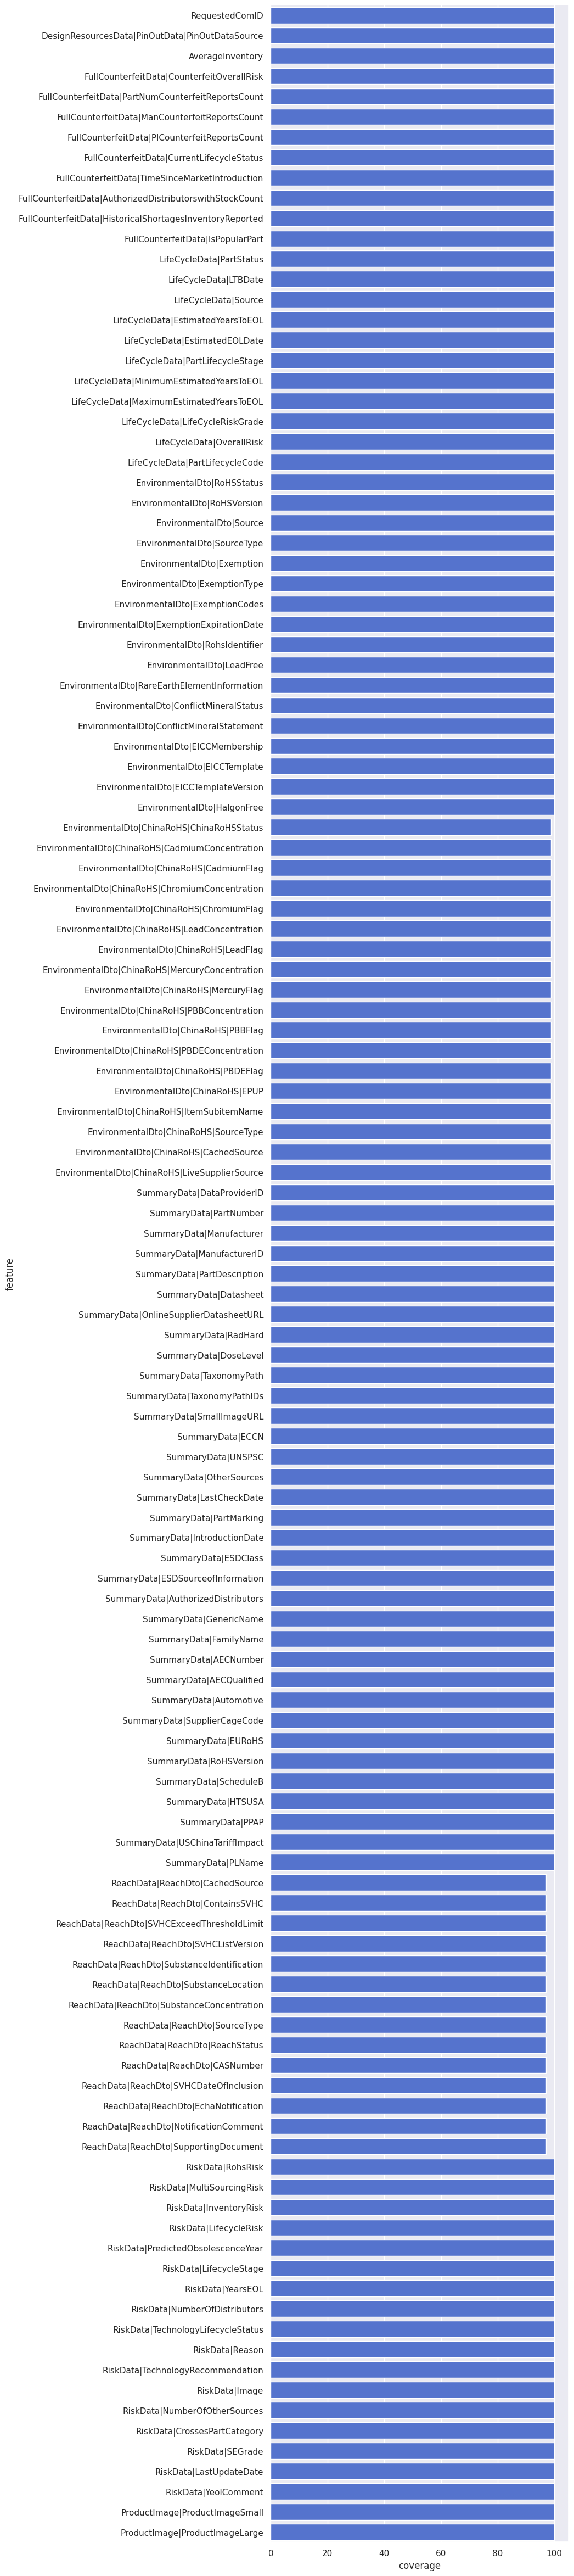

In [15]:
sb.set(rc={"figure.figsize": (7, 60)})
sb.barplot(data=tmp, y='feature', x='coverage', color='royalblue')

### 2.2. For list features

In [16]:
# Here are the list features that have values for at least 80% of the dataset
# We are going the study the feature in that lists next
# Except AllPackageData|Feature because it is a copy of PackageData|Feature
# Except History|Lifecycle because we are not going to consider this for the moment

list(filter(lambda x: usable_features[x]==list, usable_features.keys()))

['AllPackageData|Feature',
 'PackageData|Feature',
 'ParametricData|Features',
 'History|Lifecycle']

#### a) PackageData|Feature

In [17]:
package_data_features_stats = {}
for component in sylicon_expert_raw_data:
    tmp_feature_data = safe_get_nested_item(component, 'PackageData|Feature'.split('|'))
    if tmp_feature_data!=None:
        if type(tmp_feature_data) == list:
            for feature_dict in tmp_feature_data:
                package_data_features_stats["{}>{}".format('PackageData|Feature', feature_dict['FeatureName'])] = package_data_features_stats.get("{}>{}".format('PackageData|Feature', feature_dict['FeatureName']), 0) + 1
        else:
            package_data_features_stats["{}|{}".format('PackageData|Feature', tmp_feature_data['FeatureName'])] = package_data_features_stats.get("{}|{}".format('PackageData|Feature', tmp_feature_data['FeatureName']), 0) + 1

tmp = pd.DataFrame.from_dict(package_data_features_stats, orient='index')
tmp.reset_index(inplace=True)
tmp.columns = ['feature', 'coverage']
tmp['coverage'] = tmp['coverage']*100/len(sylicon_expert_raw_data)
tmp = tmp[tmp['coverage']>=60]
tmp

,feature,coverage
2,PackageData|Feature>Mounting,98.289433
18,PackageData|Feature>Number of Terminals,67.743415
19,PackageData|Feature>Package/Case,62.563372
20,PackageData|Feature>Product Depth,69.685776
21,PackageData|Feature>Product Diameter,68.554075
22,PackageData|Feature>Product Height,69.677099
23,PackageData|Feature>Product Length,69.688255
24,PackageData|Feature>Product Weight,68.562752
26,PackageData|Feature>Terminal Pitch,66.562132
27,PackageData|Feature>Termination Style,66.264642


In [18]:
final_features_coverage_df = pd.concat([final_features_coverage_df, tmp])

<AxesSubplot: xlabel='coverage', ylabel='feature'>

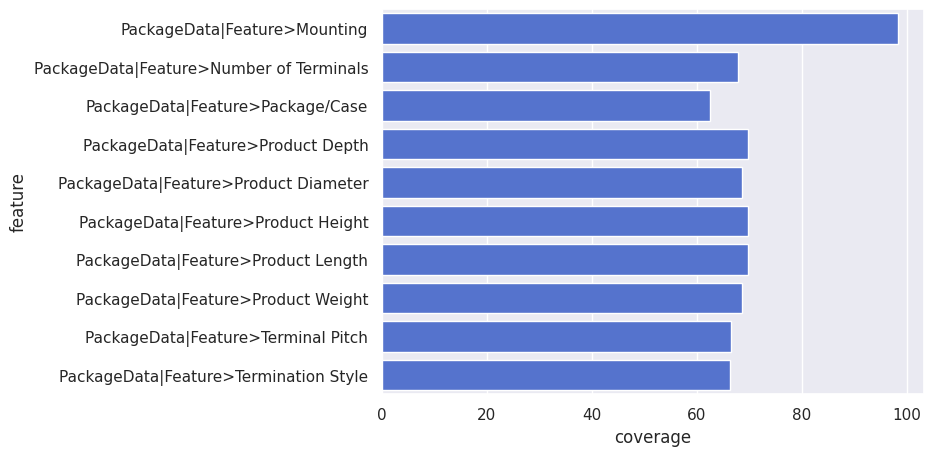

In [19]:
sb.set(rc={"figure.figsize": (7, 5)})
sb.barplot(data=tmp, y='feature', x='coverage', color='royalblue')

#### b) ParametricData|Features

In [20]:
parametric_data_features_stats = {}
for component in sylicon_expert_raw_data:
    tmp_feature_data = safe_get_nested_item(component, 'ParametricData|Features'.split('|'))
    if tmp_feature_data!=None:
        if type(tmp_feature_data) == list:
            for feature_dict in tmp_feature_data:
                parametric_data_features_stats["{}>{}".format('ParametricData|Features', feature_dict['FeatureName'])] = parametric_data_features_stats.get("{}>{}".format('ParametricData|Features', feature_dict['FeatureName']), 0) + 1
        else:
            parametric_data_features_stats["{}|{}".format('ParametricData|Features', tmp_feature_data['FeatureName'])] = parametric_data_features_stats.get("{}|{}".format('ParametricData|Features', tmp_feature_data['FeatureName']), 0) + 1

tmp = pd.DataFrame.from_dict(parametric_data_features_stats, orient='index')
tmp.reset_index(inplace=True)
tmp.columns = ['feature', 'coverage']
tmp['coverage'] = tmp['coverage']*100/len(sylicon_expert_raw_data)
tmp = tmp[tmp['coverage']>=60]
tmp

,feature,coverage
11,ParametricData|Features>Life Cycle,97.431670
18,ParametricData|Features>Maximum Operating Temp...,96.115277
21,ParametricData|Features>Minimum Operating Temp...,95.997521
27,ParametricData|Features>Packaging,83.924388
33,ParametricData|Features>ROHS,97.682058
39,ParametricData|Features>Temperature Grade,67.593430
51,ParametricData|Features>Mounting,69.818407
53,ParametricData|Features>Number of Terminals,67.980167
54,ParametricData|Features>Operating Temperature,68.769755
59,ParametricData|Features>Product Height,63.096374


In [21]:
final_features_coverage_df = pd.concat([final_features_coverage_df, tmp])

<AxesSubplot: xlabel='coverage', ylabel='feature'>

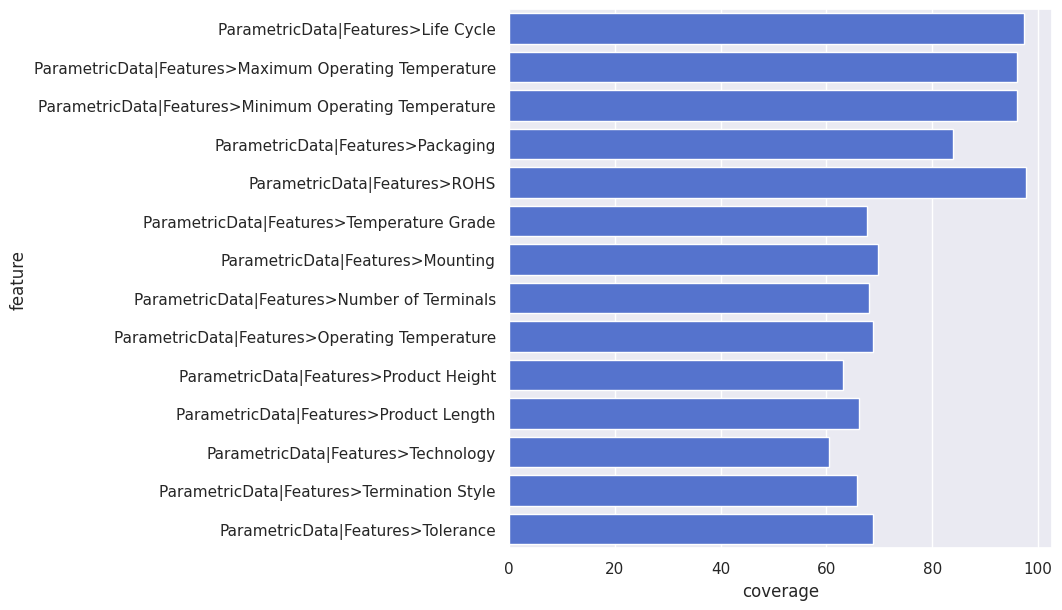

In [22]:
sb.set(rc={"figure.figsize": (7, 7)})
sb.barplot(data=tmp, y='feature', x='coverage', color='royalblue')

<AxesSubplot: xlabel='coverage', ylabel='feature'>

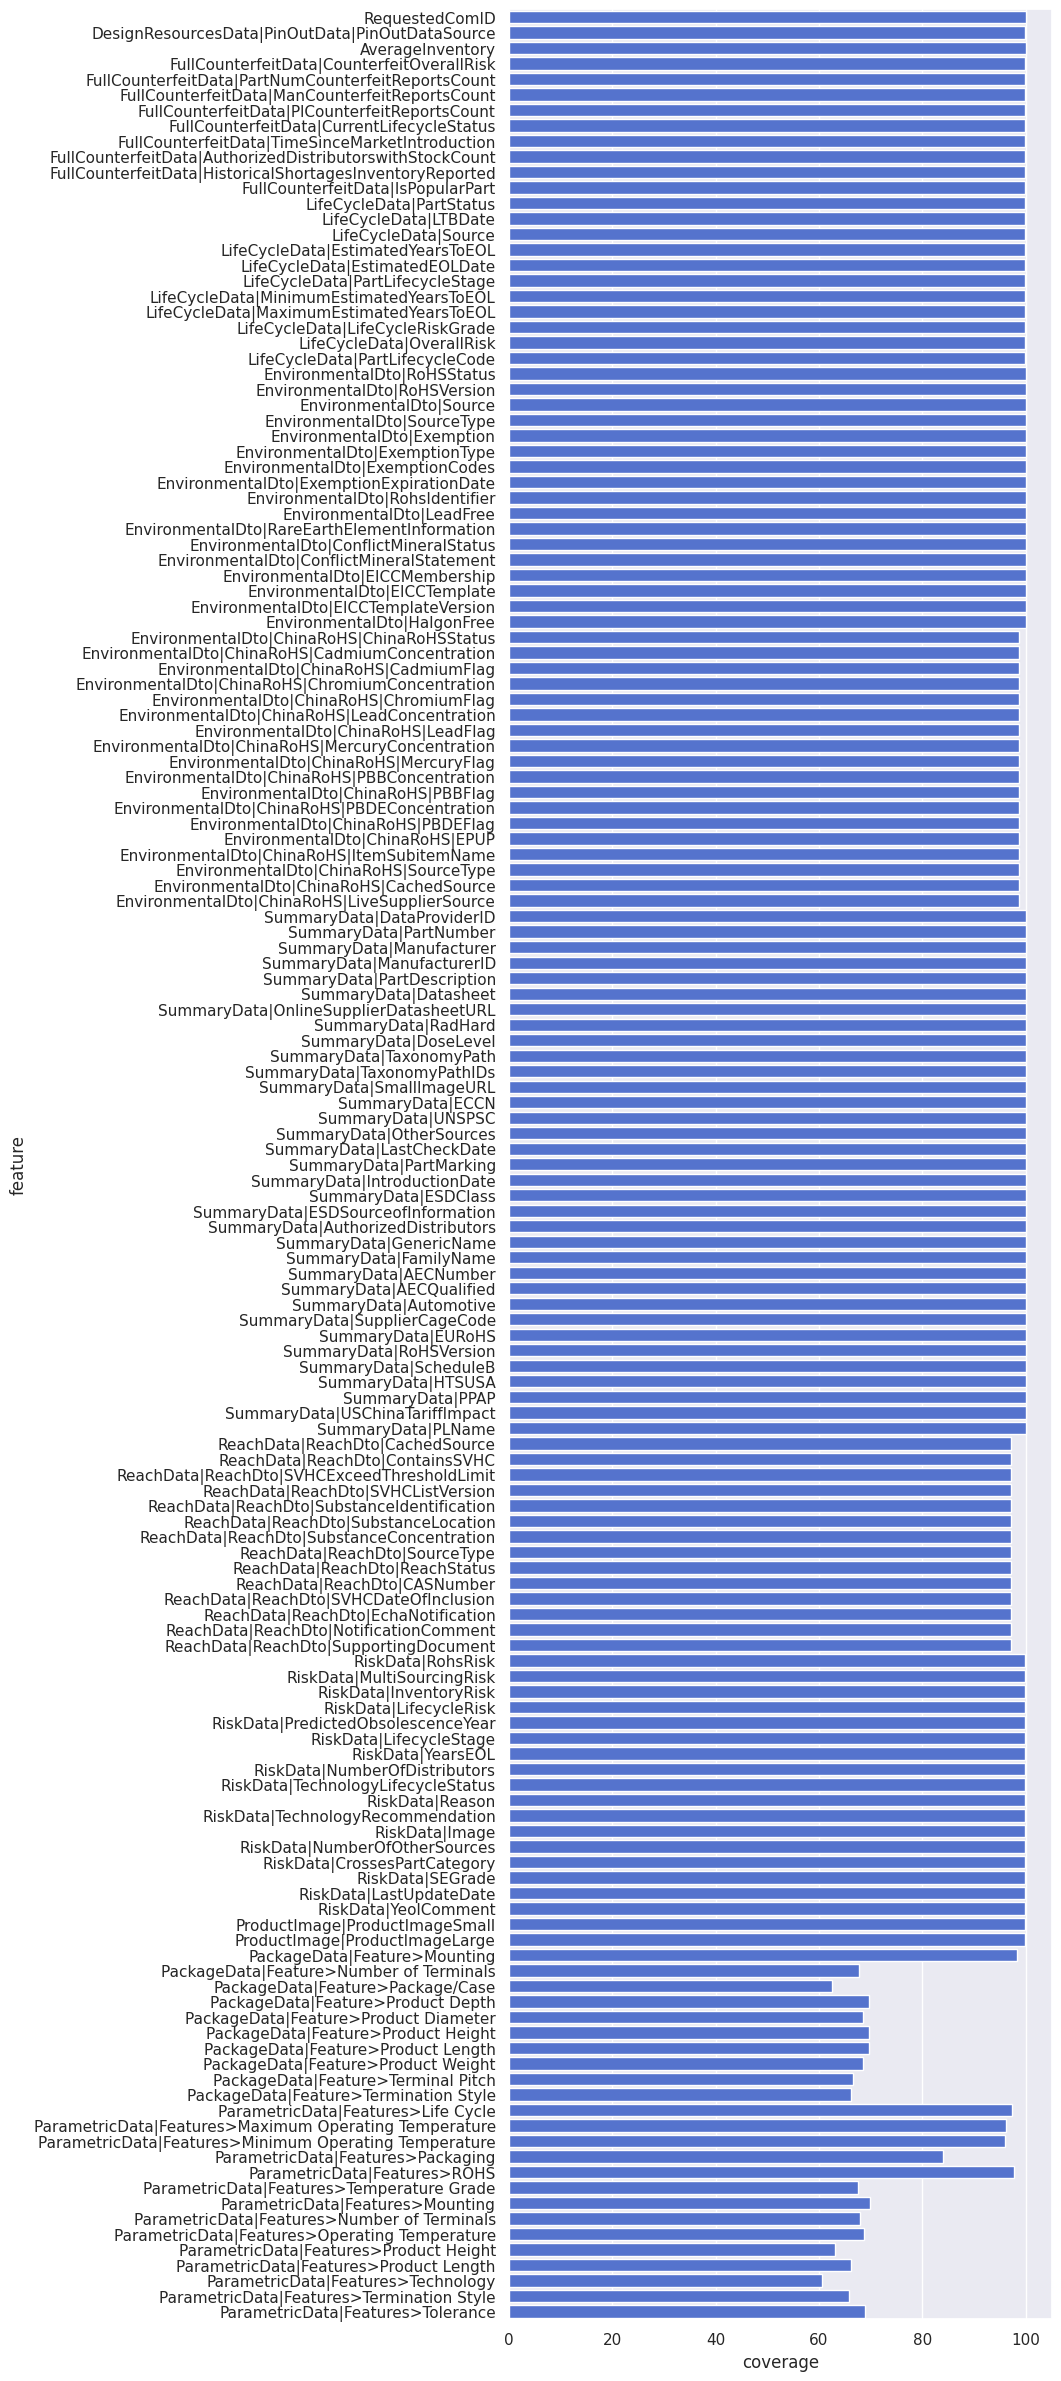

In [23]:
sb.set(rc={"figure.figsize": (7, 30)})
sb.barplot(data=final_features_coverage_df, y='feature', x='coverage', color='royalblue')

## 3. Final DataFrame construction

In [24]:
def get_feature_from_list_feature_group(data: dict, feature_path: str):
    tmp = safe_get_nested_item(component, feature_path.split('>')[0].split('|'))
    if tmp!=None:
        feature_name = feature_path.split('>')[1]
        if type(tmp) == list:
            for feature_dict in tmp:
                if feature_dict['FeatureName'] == feature_name:
                    return {'Value': feature_dict.get('FeatureValue', None), 'Unit': feature_dict.get('FeatureUnit', None)}
        else:
            return {'Value': tmp.get('FeatureValue', None), 'Unit': tmp.get('FeatureUnit', None)}
    else:
        return None

In [25]:
pre_data_dict = []
for component in sylicon_expert_raw_data:
    tmp = {}
    for feature_path in final_features_coverage_df.feature.values:
        if '>' in feature_path:
            x = get_feature_from_list_feature_group(component, feature_path)
            if x!=None:
                tmp["{}:Value".format(feature_path)] = x['Value']
                tmp["{}:Unit".format(feature_path)] = x['Unit']
            else:
                tmp["{}:Value".format(feature_path)] = None
                tmp["{}:Unit".format(feature_path)] = None
        else:
            tmp[feature_path] = safe_get_nested_item(component, feature_path.split('|'))
    pre_data_dict.append(tmp)

In [26]:
final_parts_data = pd.DataFrame(pre_data_dict)
final_unique_parts = set(df_alternates_collected.original_mpn.values).union(df_alternates_collected.alternate_mpn.values)
final_parts_data['transformed_mpn'] = final_parts_data['SummaryData|PartNumber'].apply(lambda x: re.sub(r'[^\w]', '', str(x).lower()))
final_parts_data = final_parts_data[final_parts_data['transformed_mpn'].apply(lambda x: x in final_unique_parts)]

# This is to avoid having some parts multiple times
final_parts_data['number_of_na'] = final_parts_data.apply(lambda x: x.isna().sum(), axis=1)
final_parts_data['mpn_group_rank'] = final_parts_data.sort_values(['number_of_na']).groupby(['transformed_mpn']).cumcount()
final_parts_data = final_parts_data[final_parts_data['mpn_group_rank'] == 0]
final_parts_data = final_parts_data.drop(columns=['number_of_na', 'mpn_group_rank'])

In [27]:
final_parts_data.to_csv("../data/final_parts_dataset.csv", index=False)

## 4. Data Cleaning

In [197]:
url_features = ['DesignResourcesData|PinOutData|PinOutDataSource', 'LifeCycleData|Source', 'EnvironmentalDto|Source', 'EnvironmentalDto|ConflictMineralStatement', 'EnvironmentalDto|EICCTemplate',
            'EnvironmentalDto|ChinaRoHS|CachedSource', 'EnvironmentalDto|ChinaRoHS|LiveSupplierSource', 'SummaryData|Datasheet', 'SummaryData|OnlineSupplierDatasheetURL', 'SummaryData|SmallImageURL',
            'SummaryData|ESDSourceofInformation', 'ReachData|ReachDto|CachedSource', 'ReachData|ReachDto|SupportingDocument', 'ProductImage|ProductImageSmall', 'ProductImage|ProductImageLarge']
features_to_drop_before_clean = url_features + [
    'RequestedComID', # Is not an inner property
    'SummaryData|DataProviderID', # Is not an inner property
    'SummaryData|PartNumber', # Is not an inner property
    'SummaryData|Manufacturer', # Is not an inner property
    'SummaryData|ManufacturerID', # Is not an inner property
    'SummaryData|TaxonomyPath', # Is not an inner property
    'SummaryData|TaxonomyPathIDs', # Is not an inner property
    'SummaryData|GenericName', # Is not an inner property
    'SummaryData|FamilyName', # Is not an inner property
    'SummaryData|SupplierCageCode', # Is not an inner property
    'SummaryData|ScheduleB', # Is not an inner property
    'SummaryData|HTSUSA', # Is not an inner property
    'SummaryData|PPAP', # Is not an inner property
    'RiskData|TechnologyLifecycleStatus', # No value
    'RiskData|Reason', # No value
    'RiskData|TechnologyRecommendation', # No value
    'RiskData|Image', # No value
    'RiskData|LastUpdateDate', # No Value
    'PackageData|Feature>Mounting:Unit',
    'PackageData|Feature>Number of Terminals:Unit',
    'PackageData|Feature>Package/Case:Unit',
    'PackageData|Feature>Product Depth:Unit',
    'PackageData|Feature>Product Diameter:Unit',
    'PackageData|Feature>Product Height:Unit',
    'PackageData|Feature>Product Length:Unit',
    'PackageData|Feature>Product Weight:Unit',
    'PackageData|Feature>Terminal Pitch:Unit',
    'PackageData|Feature>Termination Style:Unit',
    'ParametricData|Features>Life Cycle:Unit',
    'ParametricData|Features>Maximum Operating Temperature:Unit',
    'ParametricData|Features>Minimum Operating Temperature:Unit',
    'ParametricData|Features>Packaging:Unit',
    'ParametricData|Features>ROHS:Unit',
    'ParametricData|Features>Temperature Grade:Unit',
    'ParametricData|Features>Mounting:Unit',
    'ParametricData|Features>Number of Terminals:Unit',
    'ParametricData|Features>Operating Temperature:Value', # Repetition
    'ParametricData|Features>Operating Temperature:Unit', # Repetition
    'ParametricData|Features>Product Height:Unit',
    'ParametricData|Features>Product Length:Unit',
    'ParametricData|Features>Technology:Unit',
    'ParametricData|Features>Termination Style:Unit',
    'ParametricData|Features>Tolerance:Unit'
]
features_to_drop_after_clean = [
    'PackageData|Feature>Product Weight:Value', # Replaced with MinValue and MaxValue
    'PackageData|Feature>Product Weight:Unit'
]

In [194]:
def clean_entry(x):
    # Numeric Features
    def clean_numeric_feature(numeric_feature):
        try:
            x[numeric_feature] = float(re.findall(r"\d+\.?\d*", str(x[numeric_feature]))[0])
        except:
            x[numeric_feature] = np.nan
    clean_numeric_feature('AverageInventory')
    clean_numeric_feature('FullCounterfeitData|CounterfeitOverallRisk')
    clean_numeric_feature('FullCounterfeitData|PartNumCounterfeitReportsCount')
    clean_numeric_feature('FullCounterfeitData|ManCounterfeitReportsCount')
    clean_numeric_feature('FullCounterfeitData|PlCounterfeitReportsCount')
    clean_numeric_feature('FullCounterfeitData|TimeSinceMarketIntroduction')
    clean_numeric_feature('FullCounterfeitData|AuthorizedDistributorswithStockCount')
    clean_numeric_feature('LifeCycleData|EstimatedYearsToEOL')
    clean_numeric_feature('LifeCycleData|EstimatedEOLDate')
    clean_numeric_feature('LifeCycleData|MinimumEstimatedYearsToEOL')
    clean_numeric_feature('LifeCycleData|MaximumEstimatedYearsToEOL')
    clean_numeric_feature('LifeCycleData|OverallRisk')
    clean_numeric_feature('SummaryData|OtherSources')
    clean_numeric_feature('SummaryData|AuthorizedDistributors')
    clean_numeric_feature('ReachData|ReachDto|SubstanceConcentration')
    clean_numeric_feature('RiskData|PredictedObsolescenceYear')
    clean_numeric_feature('RiskData|YearsEOL')
    clean_numeric_feature('RiskData|NumberOfDistributors')
    clean_numeric_feature('RiskData|NumberOfOtherSources')
    clean_numeric_feature('RiskData|SEGrade')
    clean_numeric_feature('PackageData|Feature>Number of Terminals:Value')
    clean_numeric_feature('PackageData|Feature>Product Depth:Value')
    clean_numeric_feature('PackageData|Feature>Product Diameter:Value')
    clean_numeric_feature('PackageData|Feature>Product Height:Value')
    clean_numeric_feature('PackageData|Feature>Product Length:Value')
    try:
        tmp = re.findall(r"\d+\.?\d*", str(x['PackageData|Feature>Product Weight:Value']))
        x['PackageData|Feature>Product Weight:MinValue'] = float(tmp[0])
        if len(tmp)!=1:
            x['PackageData|Feature>Product Weight:MaxValue'] = float(tmp[1])
        else:
            x['PackageData|Feature>Product Weight:MaxValue'] = float(tmp[0])
    except:
        x['PackageData|Feature>Product Weight:MinValue'] = np.nan
        x['PackageData|Feature>Product Weight:MaxValue'] = np.nan
    clean_numeric_feature('PackageData|Feature>Terminal Pitch:Value')
    clean_numeric_feature('ParametricData|Features>Maximum Operating Temperature:Value')
    clean_numeric_feature('ParametricData|Features>Minimum Operating Temperature:Value')
    clean_numeric_feature('ParametricData|Features>Number of Terminals:Value')
    clean_numeric_feature('ParametricData|Features>Product Height:Value')
    clean_numeric_feature('ParametricData|Features>Product Length:Value')
    clean_numeric_feature('ParametricData|Features>Tolerance:Value')
    
    # Date Features
    def clean_date_feature(date_feature):
        try:
            x[date_feature] =  datetime.datetime.strptime(str(x[date_feature]), "%b %d, %Y")
        except:
            x[date_feature] = 'Empty Date'
    clean_date_feature('LifeCycleData|LTBDate')
    clean_date_feature('EnvironmentalDto|ExemptionExpirationDate')
    clean_date_feature('SummaryData|LastCheckDate')
    clean_date_feature('SummaryData|IntroductionDate')
    clean_date_feature('ReachData|ReachDto|SVHCListVersion')
    clean_date_feature('ReachData|ReachDto|SVHCDateOfInclusion')

    # Categorical Features
    def clean_cat_feature(cat_feature):
        try:
            x[cat_feature] = str(x[cat_feature])
            if x[cat_feature] == '':
                x[cat_feature] = 'Empty Cat'
            elif x[cat_feature] == 'None':
                x[cat_feature] = 'Missing Feature'
        except:
            x[cat_feature] = 'Empty Cat'
    clean_cat_feature('FullCounterfeitData|CurrentLifecycleStatus')
    clean_cat_feature('FullCounterfeitData|HistoricalShortagesInventoryReported')
    clean_cat_feature('FullCounterfeitData|IsPopularPart')
    clean_cat_feature('LifeCycleData|PartStatus')
    clean_cat_feature('LifeCycleData|PartLifecycleStage')
    clean_cat_feature('LifeCycleData|LifeCycleRiskGrade')
    clean_cat_feature('LifeCycleData|PartLifecycleCode')
    clean_cat_feature('EnvironmentalDto|RoHSStatus')
    clean_cat_feature('EnvironmentalDto|RoHSVersion')
    clean_cat_feature('EnvironmentalDto|SourceType')
    clean_cat_feature('EnvironmentalDto|Exemption')
    clean_cat_feature('EnvironmentalDto|ExemptionCodes')
    clean_cat_feature('EnvironmentalDto|RohsIdentifier')
    clean_cat_feature('EnvironmentalDto|LeadFree')
    clean_cat_feature('EnvironmentalDto|RareEarthElementInformation')
    clean_cat_feature('EnvironmentalDto|ConflictMineralStatus')
    clean_cat_feature('EnvironmentalDto|EICCMembership')
    clean_cat_feature('EnvironmentalDto|EICCTemplateVersion')
    clean_cat_feature('EnvironmentalDto|HalgonFree')
    clean_cat_feature('EnvironmentalDto|ChinaRoHS|ChinaRoHSStatus')
    clean_cat_feature('EnvironmentalDto|ChinaRoHS|CadmiumConcentration')
    clean_cat_feature('EnvironmentalDto|ChinaRoHS|CadmiumFlag')
    clean_cat_feature('EnvironmentalDto|ChinaRoHS|ChromiumConcentration')
    clean_cat_feature('EnvironmentalDto|ChinaRoHS|ChromiumFlag')
    clean_cat_feature('EnvironmentalDto|ChinaRoHS|LeadConcentration')
    clean_cat_feature('EnvironmentalDto|ChinaRoHS|LeadFlag')
    clean_cat_feature('EnvironmentalDto|ChinaRoHS|MercuryConcentration')
    clean_cat_feature('EnvironmentalDto|ChinaRoHS|MercuryFlag')
    clean_cat_feature('EnvironmentalDto|ChinaRoHS|PBBConcentration')
    clean_cat_feature('EnvironmentalDto|ChinaRoHS|PBBFlag')
    clean_cat_feature('EnvironmentalDto|ChinaRoHS|PBDEConcentration')
    clean_cat_feature('EnvironmentalDto|ChinaRoHS|PBDEFlag')
    clean_cat_feature('EnvironmentalDto|ChinaRoHS|SourceType')
    clean_cat_feature('SummaryData|RadHard')
    clean_cat_feature('SummaryData|DoseLevel')
    clean_cat_feature('SummaryData|ECCN')
    clean_cat_feature('SummaryData|UNSPSC')
    clean_cat_feature('SummaryData|PartMarking')
    clean_cat_feature('SummaryData|ESDClass')
    clean_cat_feature('SummaryData|AECNumber')
    clean_cat_feature('SummaryData|AECQualified')
    clean_cat_feature('SummaryData|Automotive')
    clean_cat_feature('SummaryData|EURoHS')
    clean_cat_feature('SummaryData|RoHSVersion')
    clean_cat_feature('SummaryData|USChinaTariffImpact')
    clean_cat_feature('ReachData|ReachDto|ContainsSVHC')
    clean_cat_feature('ReachData|ReachDto|SVHCExceedThresholdLimit')
    clean_cat_feature('ReachData|ReachDto|SubstanceIdentification')
    clean_cat_feature('ReachData|ReachDto|SourceType')
    clean_cat_feature('ReachData|ReachDto|ReachStatus')
    clean_cat_feature('ReachData|ReachDto|CASNumber')
    clean_cat_feature('ReachData|ReachDto|EchaNotification')
    clean_cat_feature('RiskData|RohsRisk')
    clean_cat_feature('RiskData|MultiSourcingRisk')
    clean_cat_feature('RiskData|InventoryRisk')
    clean_cat_feature('RiskData|LifecycleRisk')
    clean_cat_feature('RiskData|LifecycleStage')
    clean_cat_feature('RiskData|CrossesPartCategory')
    clean_cat_feature('PackageData|Feature>Mounting:Value')
    clean_cat_feature('PackageData|Feature>Package/Case:Value')
    clean_cat_feature('PackageData|Feature>Termination Style:Value')
    clean_cat_feature('ParametricData|Features>Life Cycle:Value')
    clean_cat_feature('ParametricData|Features>Packaging:Value')
    clean_cat_feature('ParametricData|Features>ROHS:Value')
    clean_cat_feature('ParametricData|Features>Temperature Grade:Value')
    clean_cat_feature('ParametricData|Features>Mounting:Value')
    clean_cat_feature('ParametricData|Features>Technology:Value')
    clean_cat_feature('ParametricData|Features>Termination Style:Value')
    
    # Textual Features
    def clean_textual_feature(textual_feature):
        try:
            x[textual_feature] = str(x[textual_feature])
            if x[textual_feature] in ('', 'None'):
                x[textual_feature] = ''
        except:
            x[textual_feature] = ''
    clean_textual_feature('EnvironmentalDto|ExemptionType')
    clean_textual_feature('SummaryData|PartDescription')
    clean_textual_feature('SummaryData|PLName')
    clean_textual_feature('ReachData|ReachDto|SubstanceLocation')
    clean_textual_feature('RiskData|YeolComment')

    return x

In [196]:
final_parts_data.drop(columns=features_to_drop_before_clean).apply(clean_entry, axis=1)

,AverageInventory,FullCounterfeitData|CounterfeitOverallRisk,FullCounterfeitData|PartNumCounterfeitReportsCount,FullCounterfeitData|ManCounterfeitReportsCount,FullCounterfeitData|PlCounterfeitReportsCount,FullCounterfeitData|CurrentLifecycleStatus,FullCounterfeitData|TimeSinceMarketIntroduction,FullCounterfeitData|AuthorizedDistributorswithStockCount,FullCounterfeitData|HistoricalShortagesInventoryReported,FullCounterfeitData|IsPopularPart,LifeCycleData|PartStatus,LifeCycleData|LTBDate,LifeCycleData|EstimatedYearsToEOL,LifeCycleData|EstimatedEOLDate,LifeCycleData|PartLifecycleStage,LifeCycleData|MinimumEstimatedYearsToEOL,LifeCycleData|MaximumEstimatedYearsToEOL,LifeCycleData|LifeCycleRiskGrade,LifeCycleData|OverallRisk,LifeCycleData|PartLifecycleCode,EnvironmentalDto|RoHSStatus,EnvironmentalDto|RoHSVersion,EnvironmentalDto|SourceType,EnvironmentalDto|Exemption,EnvironmentalDto|ExemptionType,EnvironmentalDto|ExemptionCodes,EnvironmentalDto|ExemptionExpirationDate,EnvironmentalDto|RohsIdentifier,EnvironmentalDto|LeadFree,EnvironmentalDto|RareEarthElementInformation,EnvironmentalDto|ConflictMineralStatus,EnvironmentalDto|EICCMembership,EnvironmentalDto|EICCTemplateVersion,EnvironmentalDto|HalgonFree,EnvironmentalDto|ChinaRoHS|ChinaRoHSStatus,EnvironmentalDto|ChinaRoHS|CadmiumConcentration,EnvironmentalDto|ChinaRoHS|CadmiumFlag,EnvironmentalDto|ChinaRoHS|ChromiumConcentration,EnvironmentalDto|ChinaRoHS|ChromiumFlag,EnvironmentalDto|ChinaRoHS|LeadConcentration,EnvironmentalDto|ChinaRoHS|LeadFlag,EnvironmentalDto|ChinaRoHS|MercuryConcentration,EnvironmentalDto|ChinaRoHS|MercuryFlag,EnvironmentalDto|ChinaRoHS|PBBConcentration,EnvironmentalDto|ChinaRoHS|PBBFlag,EnvironmentalDto|ChinaRoHS|PBDEConcentration,EnvironmentalDto|ChinaRoHS|PBDEFlag,EnvironmentalDto|ChinaRoHS|EPUP,EnvironmentalDto|ChinaRoHS|ItemSubitemName,EnvironmentalDto|ChinaRoHS|SourceType,SummaryData|PartDescription,SummaryData|RadHard,SummaryData|DoseLevel,SummaryData|ECCN,SummaryData|UNSPSC,SummaryData|OtherSources,SummaryData|LastCheckDate,SummaryData|PartMarking,SummaryData|IntroductionDate,SummaryData|ESDClass,SummaryData|AuthorizedDistributors,SummaryData|AECNumber,SummaryData|AECQualified,SummaryData|Automotive,SummaryData|EURoHS,SummaryData|RoHSVersion,SummaryData|USChinaTariffImpact,SummaryData|PLName,ReachData|ReachDto|ContainsSVHC,ReachData|ReachDto|SVHCExceedThresholdLimit,ReachData|ReachDto|SVHCListVersion,ReachData|ReachDto|SubstanceIdentification,ReachData|ReachDto|SubstanceLocation,ReachData|ReachDto|SubstanceConcentration,ReachData|ReachDto|SourceType,ReachData|ReachDto|ReachStatus,ReachData|ReachDto|CASNumber,ReachData|ReachDto|SVHCDateOfInclusion,ReachData|ReachDto|EchaNotification,ReachData|ReachDto|NotificationComment,RiskData|RohsRisk,RiskData|MultiSourcingRisk,RiskData|InventoryRisk,RiskData|LifecycleRisk,RiskData|PredictedObsolescenceYear,RiskData|LifecycleStage,RiskData|YearsEOL,RiskData|NumberOfDistributors,RiskData|NumberOfOtherSources,RiskData|CrossesPartCategory,RiskData|SEGrade,RiskData|YeolComment,PackageData|Feature>Mounting:Value,PackageData|Feature>Number of Terminals:Value,PackageData|Feature>Package/Case:Value,PackageData|Feature>Product Depth:Value,PackageData|Feature>Product Diameter:Value,PackageData|Feature>Product Height:Value,PackageData|Feature>Product Length:Value,PackageData|Feature>Terminal Pitch:Value,PackageData|Feature>Termination Style:Value,ParametricData|Features>Life Cycle:Value,ParametricData|Features>Maximum Operating Temperature:Value,ParametricData|Features>Minimum Operating Temperature:Value,ParametricData|Features>Packaging:Value,ParametricData|Features>ROHS:Value,ParametricData|Features>Temperature Grade:Value,ParametricData|Features>Mounting:Value,ParametricData|Features>Number of Terminals:Value,ParametricData|Features>Product Height:Value,ParametricData|Features>Product Length:Value,ParametricData|Features>Technology:Value,ParametricData|Features>Termination Style:Value,ParametricData|Features>Tolerance:Value

In [66]:
final_parts_data

,RequestedComID,DesignResourcesData|PinOutData|PinOutDataSource,AverageInventory,FullCounterfeitData|CounterfeitOverallRisk,FullCounterfeitData|PartNumCounterfeitReportsCount,FullCounterfeitData|ManCounterfeitReportsCount,FullCounterfeitData|PlCounterfeitReportsCount,FullCounterfeitData|CurrentLifecycleStatus,FullCounterfeitData|TimeSinceMarketIntroduction,FullCounterfeitData|AuthorizedDistributorswithStockCount,FullCounterfeitData|HistoricalShortagesInventoryReported,FullCounterfeitData|IsPopularPart,LifeCycleData|PartStatus,LifeCycleData|LTBDate,LifeCycleData|Source,LifeCycleData|EstimatedYearsToEOL,LifeCycleData|EstimatedEOLDate,LifeCycleData|PartLifecycleStage,LifeCycleData|MinimumEstimatedYearsToEOL,LifeCycleData|MaximumEstimatedYearsToEOL,LifeCycleData|LifeCycleRiskGrade,LifeCycleData|OverallRisk,LifeCycleData|PartLifecycleCode,EnvironmentalDto|RoHSStatus,EnvironmentalDto|RoHSVersion,EnvironmentalDto|Source,EnvironmentalDto|SourceType,EnvironmentalDto|Exemption,EnvironmentalDto|ExemptionType,EnvironmentalDto|ExemptionCodes,EnvironmentalDto|ExemptionExpirationDate,EnvironmentalDto|RohsIdentifier,EnvironmentalDto|LeadFree,EnvironmentalDto|RareEarthElementInformation,EnvironmentalDto|ConflictMineralStatus,EnvironmentalDto|ConflictMineralStatement,EnvironmentalDto|EICCMembership,EnvironmentalDto|EICCTemplate,EnvironmentalDto|EICCTemplateVersion,EnvironmentalDto|HalgonFree,EnvironmentalDto|ChinaRoHS|ChinaRoHSStatus,EnvironmentalDto|ChinaRoHS|CadmiumConcentration,EnvironmentalDto|ChinaRoHS|CadmiumFlag,EnvironmentalDto|ChinaRoHS|ChromiumConcentration,EnvironmentalDto|ChinaRoHS|ChromiumFlag,EnvironmentalDto|ChinaRoHS|LeadConcentration,EnvironmentalDto|ChinaRoHS|LeadFlag,EnvironmentalDto|ChinaRoHS|MercuryConcentration,EnvironmentalDto|ChinaRoHS|MercuryFlag,EnvironmentalDto|ChinaRoHS|PBBConcentration,EnvironmentalDto|ChinaRoHS|PBBFlag,EnvironmentalDto|ChinaRoHS|PBDEConcentration,EnvironmentalDto|ChinaRoHS|PBDEFlag,EnvironmentalDto|ChinaRoHS|EPUP,EnvironmentalDto|ChinaRoHS|ItemSubitemName,EnvironmentalDto|ChinaRoHS|SourceType,EnvironmentalDto|ChinaRoHS|CachedSource,EnvironmentalDto|ChinaRoHS|LiveSupplierSource,SummaryData|DataProviderID,SummaryData|PartNumber,SummaryData|Manufacturer,SummaryData|ManufacturerID,SummaryData|PartDescription,SummaryData|Datasheet,SummaryData|OnlineSupplierDatasheetURL,SummaryData|RadHard,SummaryData|DoseLevel,SummaryData|TaxonomyPath,SummaryData|TaxonomyPathIDs,SummaryData|SmallImageURL,SummaryData|ECCN,SummaryData|UNSPSC,SummaryData|OtherSources,SummaryData|LastCheckDate,SummaryData|PartMarking,SummaryData|IntroductionDate,SummaryData|ESDClass,SummaryData|ESDSourceofInformation,SummaryData|AuthorizedDistributors,SummaryData|GenericName,SummaryData|FamilyName,SummaryData|AECNumber,SummaryData|AECQualified,SummaryData|Automotive,SummaryData|SupplierCageCode,SummaryData|EURoHS,SummaryData|RoHSVersion,SummaryData|ScheduleB,SummaryData|HTSUSA,SummaryData|PPAP,SummaryData|USChinaTariffImpact,SummaryData|PLName,ReachData|ReachDto|CachedSource,ReachData|ReachDto|ContainsSVHC,ReachData|ReachDto|SVHCExceedThresholdLimit,ReachData|ReachDto|SVHCListVersion,ReachData|ReachDto|SubstanceIdentification,ReachData|ReachDto|SubstanceLocation,ReachData|ReachDto|SubstanceConcentration,ReachData|ReachDto|SourceType,ReachData|ReachDto|ReachStatus,ReachData|ReachDto|CASNumber,ReachData|ReachDto|SVHCDateOfInclusion,ReachData|ReachDto|EchaNotification,ReachData|ReachDto|NotificationComment,ReachData|ReachDto|SupportingDocument,RiskData|RohsRisk,RiskData|MultiSourcingRisk,RiskData|InventoryRisk,RiskData|LifecycleRisk,RiskData|PredictedObsolescenceYear,RiskData|LifecycleStage,RiskData|YearsEOL,RiskData|NumberOfDistributors,RiskData|TechnologyLifecycleStatus,RiskData|Reason,RiskData|TechnologyRecommendation,RiskData|Image,RiskData|NumberOfOtherSources,RiskData|CrossesPartCategory,RiskData|SEGrade,RiskData|LastUpdateDate,RiskData|YeolComment,ProductImage|ProductImageSmall,ProductImage|ProductImageLarge,PackageData|Feature>Mounting

In [189]:
final_parts_data['ParametricData|Features>Product Length:Value'].unique()

array([None, '7.3', '2', '1', '1.55', '7.2(Max)', '3.2', '1.6', '3.15',
       '6.25', '3.1', '4.5', '3.18', '5.7', '4.57', '7.2', '3.05',
       '21.68', '14.22', '7.11', '12.7', '6.1', '6.4', '11.1', '10.8',
       '2.01', '3.3', '6', '9.53', '6.35', '3.81(Max)', '10.4', '6.6',
       '6.3', '5.6', '1.02', '6.2', '1.85', '4.6', '22.86', '5.08(Max)',
       '3.5', '5', '4.83', '0.6', '2.2', '1.75', '9.25', '2.92', '22.45',
       '11', '1.8', '13.5(Max)', '6.5', '0.99', '11.63', '21.79', '2.03',
       '23.9', '20.27', '3.4', '9.09', '9.5', '12.95', '0.61', '4.495',
       '15.5', '2.9', '4(Max)', '2.06', '9', '45.8', '3.81', '1.63',
       '5.1', '3(Max)', '6.8', '7.5(Max)', '1.58', '3.6', '22.3', '7.6',
       '7.4', '9.6', '6.6(Max)', '10', '21.72', '4.9', '13.9', '9.91',
       '12.1', '7.5', '12.4', '12', '25.15', '4', '3.06', '15', '4.7',
       '10.5', '14.2', '3.7', '3.4(Max)', '14.05', '22', '26.5', '13.8',
       '22.23', '15.19', '1.05', '7.06', '19.8', '1.1', '15.06', '1.7

In [190]:
final_parts_data['ParametricData|Features>Product Length:Value'].apply(lambda x: str(str(x).split(" ")[1:]) if len(str(x).split(" "))>1 else "").unique()

array([''], dtype=object)

In [78]:
datetime.datetime.strptime('Jan 18, 2020', "%b %d, %Y")

datetime.datetime(2020, 1, 18, 0, 0)

In [166]:
final_parts_data['PackageData|Feature>Product Weight:Value'][final_parts_data['PackageData|Feature>Product Weight:Value'].apply(lambda x: 'to' in str(x))]

611        0.128 to 0.164 g
2613         0.92 to 1.23 g
6373             1.8 to 4.8
10764     0.028 to 0.0313 g
11863        0.46 to 0.48 g
13005        1.97 to 2.25 g
22257          0.35 to 0.37
22329    0.0459 to 0.0502 g
22826     0.028 to 0.0313 g
24247     0.0383 to 0.041 g
24445        0.92 to 1.23 g
25117     0.0383 to 0.041 g
29519     0.002 to 0.0032 g
32936        1.97 to 2.25 g
41489        0.33 to 0.36 g
43912     0.002 to 0.0032 g
47320          3.7 to 4.4 g
48066              1 to 3 g
50665          3.7 to 4.4 g
56851          3.8 to 4.6 g
57041          2.8 to 3.2 g
57272        0.46 to 0.48 g
57441        0.92 to 1.23 g
61156        0.95 to 1.25 g
62740     0.002 to 0.0032 g
65080          0.92 to 1.23
75323        0.92 to 1.23 g
76096        2.73 to 5.12 g
78520          2.8 to 3.2 g
79236            2 to 2.7 g
Name: PackageData|Feature>Product Weight:Value, dtype: object

In [191]:
re.findall(r"\d+\.?\d*", str('0.128 to 0.164 g'))

['0.128', '0.164']